In [1]:
from torch.utils.data import DataLoader
from collections import Counter
from torchvision import datasets
from experiment import tune_architecture, tune_hyperparameters
from preprocessing import visualize_images, verify_image_sizes, plot_bar
from model import Model, ResidualModel, train, predict
import torch
import pandas as pd
import torchvision.transforms as transforms

## Data analysis and preprocessing

In [2]:
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
dataset = datasets.ImageFolder("data/train", transform=basic_transforms)
analysis_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
classes = dataset.classes

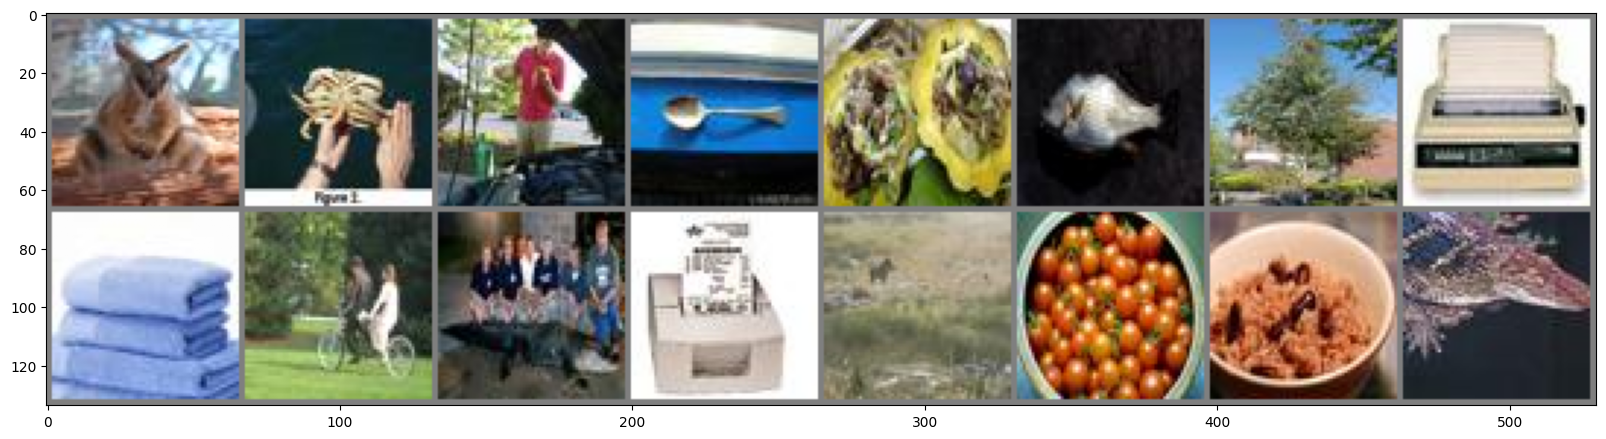

kangaroo  crab gauge spoon squash  fish birch printer towel bicycle crocodilian printer swine tomato  bean crocodilian


In [4]:
visualize_images(analysis_loader, classes, figsize=(20,10))

In [5]:
# verify_image_sizes(analysis_loader)

All images are 64x64 pixels with three color channels (RGB).

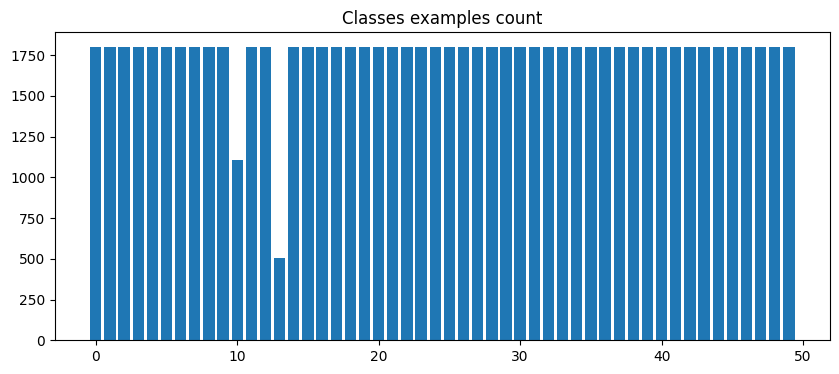

In [6]:
class_examples_num = dict(Counter(dataset.targets))
plot_bar(class_examples_num, "Classes examples count",  size=(10, 4))

In [7]:
print(f"{classes[10]}: {class_examples_num[10]}, {classes[13]}: {class_examples_num[13]}")


bread: 1108, carbon: 503


Dataset is nearly completely balanced at 1800 examples for almost all classes. Only class 10 (bread) and class 13(carbon) have respectively 1108 and 503 examples.

In [8]:
print("Dataset size: ", len(dataset))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Train set size: ", len(train_dataset))
print("Validation set size: ", len(val_dataset))

Dataset size:  88011
Train set size:  70408
Validation set size:  17603


In [9]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(24),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset.dataset.transform = train_transforms

# Model and training

In [10]:
architectures = [
        [
                {"conv": (3, 32, 3, 1, 1), "batch_norm": 32, "activation": True, "max_pool": (2, 2)},
                {"conv": (32, 64, 3, 1, 1), "batch_norm": 64, "activation": True, "max_pool": (2, 2)},
                {"flatten": True},
                {"linear": (16*16*64, 512), "activation": True},
                {"dropout": 0.5, "linear": (512, 50)}
        ],
        [
                {"conv": (3, 32, 5, 1, 2), "batch_norm": 32, "activation": True, "max_pool": (2, 2)},
                {"conv": (32, 64, 3, 1, 1), "batch_norm": 64, "activation": True, "max_pool": (2, 2)},
                {"flatten": True},
                {"linear": (14*14*64, 512), "activation": True},
                {"linear": (512, 50)}
        ],
        [
                {"conv": (3, 32, 3, 1, 1), "batch_norm": 32, "activation": True, "max_pool": (2, 2)},
                {"conv": (32, 64, 3, 1, 1), "batch_norm": 64, "activation": True, "max_pool": (2, 2)},
                {"conv": (64, 128, 3, 1, 1), "batch_norm": 128, "activation": True, "max_pool": (2, 2)},
                {"flatten": True},
                {"linear": (8*8*128, 256), "activation": True},
                {"dropout": 0.5, "linear": (256, 50)}
        ],
        [
                {"conv": (3, 64, 7, 2, 0), "activation": True, "max_pool": (2, 2)}, #64->62->31
                {"residual": [
                        {"conv": (64, 64, 3, 1, 0), "batch_norm": 64, "activation": True}, #31->29
                        {"conv": (64, 64, 3, 1, 0), "batch_norm": 64},  #29->27
                ]},
                {"activation": True},
                {"residual": [
                        {"conv": (64, 128, 3, 1, 0), "batch_norm": 128, "activation": True}, #27->25
                        {"conv": (128, 128, 3, 1, 0), "batch_norm": 128}, #25->23
                ]},
                {"activation": True},
                {"residual": [
                        {"conv": (128, 256, 3, 1, 0), "batch_norm": 256, "activation": True}, #23->21
                        {"conv": (256, 256, 3, 1, 0), "batch_norm": 256}, #21->19
                ]},
                {"activation": True},
                {"avg_pool": (2, 2)}, #19->9
                {"flatten": True},
                {"linear": (9*9*256, 512), "activation": True},
                {"dropout": 0.5, "linear": (512, 50)}
        ]
]

In [11]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# training_setup = {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None}
# losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(train_dataset, val_dataset, architectures, training_setup, device)

In [14]:
architecture = [
                {"conv": (3, 64, 7, 1, 3), "batch_norm": 64, "activation": True, "max_pool": (2, 2)}, #64->64->32
                {"residual": [
                        {"conv": (64, 64, 3, 1, 1), "batch_norm": 64, "activation": True}, #32->32
                        {"conv": (64, 64, 3, 1, 1), "batch_norm": 64},  #32->32
                ]},
                {"activation": True},
                {"residual": [
                        {"conv": (64, 128, 3, 2, 1), "batch_norm": 128, "activation": True}, #32->16
                        {"conv": (128, 128, 3, 1, 1), "batch_norm": 128}, #16->16
                ]},
                {"activation": True},
                {"residual": [
                        {"conv": (128, 256, 3, 2, 1), "batch_norm": 256, "activation": True}, #16->8
                        {"conv": (256, 256, 3, 1, 1), "batch_norm": 256}, #8->8
                ]},
                {"activation": True},
                {"avg_pool": (8, 8)}, #8->1
                {"flatten": True},
                {"dropout": 0.5, "linear": (256, 50)},
        ]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 1, "lr": 3e-4, "batch_size": 256, "class_weights": None}
model = ResidualModel(architecture, device)
train(model, train_dataset, training_setup["epochs"], training_setup["lr"], training_setup["batch_size"], training_setup["class_weights"], verbose=True)
print("Training done")

Training started
Epoch: 0, loss: 3.4873812190000564
Training done


In [ ]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

In [ ]:
model = Model(architectures, device="cuda" if torch.cuda.is_available() else "cpu")
train(model, train_dataset, epochs=10, lr=0.001, batch_size=32, verbose=True)

In [ ]:
hyperparameters = [
    {"epochs": 60, "lr": 3e-2, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-2, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 128, "class_weights": None},
    ]
final_model, losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_hyperparameters(train_dataset, val_dataset, architectures[1], hyperparameters, device)

In [ ]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

In [ ]:
df_test = pd.read_csv("data/test_all.csv")

# Conclusions